In [12]:
__file__ = 'A1.ipynb'
import sys
import pathlib
sys.path.append(str(pathlib.Path(__file__).absolute().parent.parent)+"/FP4_lib")
import functions as f
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from uncertainties import unumpy as up
from uncertainties import ufloat
import scipy.constants as const
import scipy.fft as fft
import lmfit

In [13]:
with open('Data/Aufg_6.2.txt','r') as tf:
    data = np.genfromtxt(tf).T
with open('Res/cp-cal_res.txt','r') as tf:
    cal = np.genfromtxt(tf).T

data = f.channel_to_pos(data,cal)

In [14]:
yerr = 0.035339825186025027*np.abs(data[1])

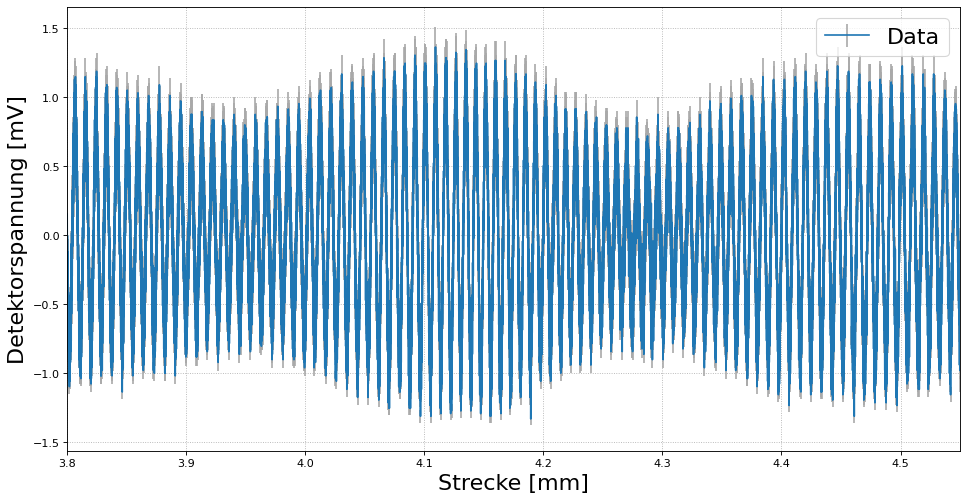

In [22]:
f.figsize(2)
plt.errorbar(data[0],data[1],yerr=yerr,label = 'Data',ecolor='darkgray')

f.form([3.8,4.55],xlabel='Strecke [mm]',ylabel='Detektorspannung [mV]',name='Res/A6_interferogramm.pdf')

Wavelength: 3.479697331567566e-06 m


/tmp/ipykernel_5978/2412301991.py:20: RuntimeWarning: divide by zero encountered in divide
  freqs = 1/freqs


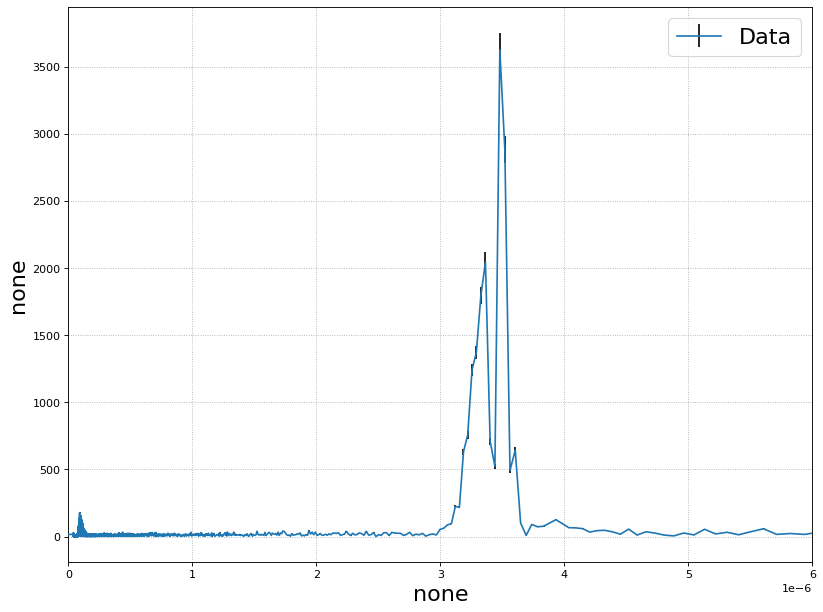

In [16]:
freq_scale = 2/5.127868608985219*1e-3

intensity = data[1]
position  = data[0]*freq_scale


intensity -= np.mean(intensity)


freqs = np.fft.fftfreq(len(intensity), d=((np.mean(np.diff(position)))))
fft_int = np.fft.fft(intensity)
fft_err = np.fft.fft(yerr)

peak_idx = np.argmax(np.abs(fft_int))
peak_freq = freqs[peak_idx]


print(f"Wavelength: {1/peak_freq} m")

freqs = 1/freqs

f.figsize(1)

plt.errorbar(freqs, np.abs(fft_int),yerr=np.abs(fft_err),ecolor='k',zorder=10,label='Data')
plt.xlim(0,0.6e-5)



#plt.vlines(3.6271e-06,0,3600,colors="r")
#plt.vlines(3.4007e-06,0,3600,colors="b")

f.form()

In [17]:
dat = [freqs, np.abs(fft_int),np.abs(fft_err)]

sorted_indices = sorted(range(len(dat[0])), key=lambda k: dat[0][k])

dat_sorted = [[dat[0][i], dat[1][i],dat[2][i]] for i in sorted_indices]

dat_sorted = np.array(dat_sorted).T

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 8
    # variables        = 3
    chi-square         = 221.753519
    reduced chi-square = 44.3507038
    Akaike info crit   = 32.5769996
    Bayesian info crit = 32.8153242
    R-squared          = 0.99991898
[[Variables]]
    amplitude:  3.1752e-04 +/- 2.9446e-05 (9.27%) (init = 0.0002973468)
    center:     3.3093e-06 +/- 8.0298e-09 (0.24%) (init = 3.309059e-06)
    sigma:      7.8505e-08 +/- 6.8836e-09 (8.77%) (init = 5.425335e-08)
    fwhm:       1.8486e-07 +/- 1.6210e-08 (8.77%) == '2.3548200*sigma'
    height:     1613.54081 +/- 200.137079 (12.40%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(center, sigma)     = 0.597
    C(amplitude, center) = 0.357
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 7
   

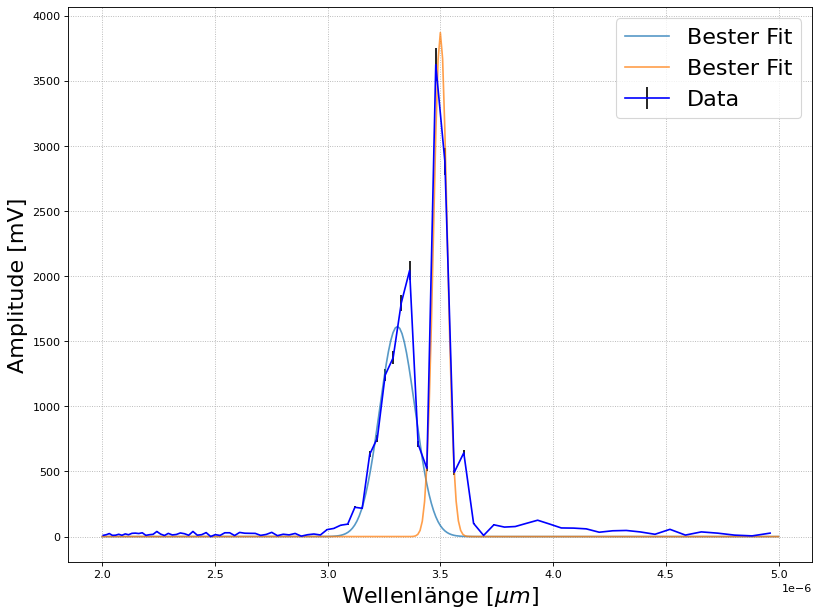

In [18]:
von,bis = f.pos(dat_sorted[0],0.2e-5),f.pos(dat_sorted[0],0.5e-5)
von1,bis1 = f.pos(dat_sorted[0],0.315e-5),f.pos(dat_sorted[0],0.3425e-5)
von2,bis2 = f.pos(dat_sorted[0],0.341e-5),f.pos(dat_sorted[0],0.37e-5)






res1 = f.gausfit(dat_sorted[1,von1:bis1],dat_sorted[0,von1:bis1],dat_sorted[2,von1:bis1])
#res1.plot()
print(res1.fit_report())

res2 = f.gausfit(dat_sorted[1,von2:bis2],dat_sorted[0,von2:bis2],dat_sorted[2,von2:bis2])
#res2.plot()
print(res2.fit_report())


plt.show()
f.figsize(1)

plt.errorbar(dat_sorted[0,von:bis],dat_sorted[1,von:bis],yerr=dat_sorted[2,von:bis],fmt='b',ecolor = 'k',label='Data')
plt.plot(np.arange(2e-6,5e-6,1e-8),res1.eval(x=np.arange(2e-6,5e-6,1e-8)),alpha=0.75,label='Bester Fit')#,color='y')
plt.plot(np.arange(2e-6,5e-6,1e-8),res2.eval(x=np.arange(2e-6,5e-6,1e-8)),alpha=0.75,label='Bester Fit')#,color='y')

f.form(xlabel=f'Wellenl√§nge [$\mu m$]',ylabel='Amplitude [mV]',name='Res/A6_fftfit.pdf')


In [19]:
von,bis = f.pos(dat_sorted[0],0.2e-5),f.pos(dat_sorted[0],0.5e-5)
von1,bis1 = f.pos(dat_sorted[0],0.25e-5),f.pos(dat_sorted[0],0.4e-5)


model_gaus3 = lmfit.models.GaussianModel(prefix='g1_')+lmfit.models.GaussianModel(prefix='g2_')
    
pars_gaus3=model_gaus3.make_params()
pars_gaus3['g1_amplitude'].set(2000)
pars_gaus3['g1_center'].set(3.3e-6,min=3.2e-6,max=3.41e-6)
pars_gaus3['g1_sigma'].set(0.3)

pars_gaus3['g2_amplitude'].set(3500)
pars_gaus3['g2_center'].set(3.5e-6,min=3.41e-6,max=3.6e-6)
pars_gaus3['g2_sigma'].set(0.3)

out_gaus = model_gaus3.fit(dat_sorted[1,von1:bis1],x=dat_sorted[0,von1:bis1],weights=1/dat_sorted[2,von1:bis1].clip(1),params=pars_gaus3,nan_policy='propagate')


#plt.errorbar(dat_sorted[0,von:bis],dat_sorted[1,von:bis],yerr=dat_sorted[2,von:bis],ecolor = 'k')
out_gaus.plot()
print(out_gaus.fit_report())


[[Model]]
    (Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 79
    # data points      = 46
    # variables        = 6
    chi-square         = 17164.6179
    reduced chi-square = 429.115447
    Akaike info crit   = 284.410346
    Bayesian info crit = 295.382195
    R-squared          = 0.99937398
##  Warning: uncertainties could not be estimated:
    g1_center:     at initial value
    g2_center:     at initial value
[[Variables]]
    g1_amplitude: -2349.55448 (init = 2000)
    g1_center:     3.3000e-06 (init = 3.3e-06)
    g1_sigma:      0.72397763 (init = 0.3)
    g2_amplitude:  989.731670 (init = 3500)
    g2_center:     3.5000e-06 (init = 3.5e-06)
    g2_sigma:      0.29986588 (init = 0.3)
    g1_fwhm:       1.70483700 == '2.3548200*g1_sigma'
    g1_height:    -1294.70391 == '0.3989423*g1_amplitude/max(1e-15, g1_sigma)'
    g2_fwhm:       0.70613016 == '2.3548200*g2_sigma'
    g2_height: 